In [ ]:
import pandas as pd
import numpy as np
from time import time
from pprint import PrettyPrinter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
pp = PrettyPrinter()

# Load

In [2]:
df_train = pd.read_csv('../data/train_clean_v2.csv', parse_dates=['date'], dtype={'fullVisitorId': 'str'})

In [3]:
target = df_train['totals.transactionRevenue'].apply(lambda x: 1 if x > 0 else 0).values
val_cols = [col for col in df_train.columns[2:] if col != 'totals.transactionRevenue']
vals = df_train[val_cols].values
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(vals)

# Funcs

In [23]:
def grid_classifier(model, train, target, parameters={}, cv=4, timed=True, verbose=True, plot=False):
    '''
    For tuning models.
    
    
        Parameters:
        -----------
    model - sklearn model
    train - array of training data
    target - array of target data
    parameters - dict of parameters the GSearcher will run over
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    verbose - boolean, printout the cv results
    plot - boolean, makes a seaborn plot of the cv results, one parameter only
    
        Returns :
        ---------
    gsearcher - fitted and searched GridSearchCV object
    '''
    if timed:
        start = time()
        passed = time() - start
        print(f'Seconds to start: {passed:.2f}')
    
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='roc_auc',
        n_jobs=4,
        cv=cv)
    gsearcher.fit(train, target)
    results = gsearcher.cv_results_
    
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')
    if verbose:
        print('Grid Scores: \n')
        pp.pprint(results)
        print(f'Best Model Parameters: {gsearcher.best_params_}')
        print(f'Best Model Score: {gsearcher.best_score_:.4f}')
    
    if plot:
        AUC_means = results['mean_test_score']
        x = range(len(AUC_means))
        model_name = str(model.__class__).split('.')[-1][:-2]
        param = list(results['params'][0].keys())[0]
        labels = [str(pair[param]) for pair in results['params']]

        plt.figure(figsize=(8,6))
        plt.scatter(x=x, y=AUC_means)
        plt.title(f'{model_name} over {param}')
        plt.xlabel(param)
        plt.ylabel('AUC Scores')
        plt.xticks(x, labels, rotation=60)
    
    return gsearcher

In [31]:
def model_validate(model, train, target, cv=5, timed=True, verbose=True, feature_importance=False):
    '''
    For validating a model's score on a single set of parameters.
    
        Paramters:
        ----------
    model - sklearn model, parameters set on instantiation
    train - array of training data
    target - array of target data
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    verbose - boolean, printout the cv_results
    feature_importance - boolean, makes a seaborn plot of the feature importance, only works for ensembles
    
        Returns:
        ---------
    model - the fitted sklearn model

    '''
    # Fit and Predict
    if timed:
        start = time()
        passed = time() - start
        print(f'Seconds to start: {passed:.2f}')
    model.fit(train, target)
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')
    
    # CV
    cv_score = cross_validation.cross_val_score(model, train, target, cv=cv, scoring='roc_auc')
    if verbose:
        print(f'CV Score : Mean - {np.mean(cv_score):.3f} | Std - {np.std(cv_score):.3f} | Min - {np.min(cv_score):.3f} | Max - {np.max(cv_score):.3f}')
    if timed:
        passed = time() - start
        print(f'Seconds to CV: {passed:.2f}')
    
    # Plots feature importance, for ensemble models only
    if feature_importance:
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    
    return model

---
# Modeling

---
## Naive Bayes

In [5]:
gaussian_gSearch = grid_classifier(GaussianNB(), scaled_vals, target)

Seconds to start: 0.00
Seconds to fit: 3.65
Grid Scores: 

{'mean_fit_time': array([1.07766914]),
 'mean_score_time': array([0.28265524]),
 'mean_test_score': array([0.95811438]),
 'mean_train_score': array([0.95815123]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.95865279]),
 'split0_train_score': array([0.95789989]),
 'split1_test_score': array([0.95655758]),
 'split1_train_score': array([0.95789333]),
 'split2_test_score': array([0.95974835]),
 'split2_train_score': array([0.95860401]),
 'split3_test_score': array([0.95749879]),
 'split3_train_score': array([0.95820768]),
 'std_fit_time': array([0.13831474]),
 'std_score_time': array([0.00886132]),
 'std_test_score': array([0.00120024]),
 'std_train_score': array([0.00029064])}
Best Model Parameters: {}
Best Model Score: 0.9581


---
## Logistic Regression

In [15]:
np.logspace(-6, 3, 10)

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03])

Seconds to start: 0.00
Seconds to fit: 75.17
Grid Scores: 

{'mean_fit_time': array([ 3.13209921,  3.4822228 ,  3.89718193,  4.60008883,  5.76942825,
        7.14954364,  8.62375522,  9.78251827, 10.88093817, 10.19381177]),
 'mean_score_time': array([0.09875947, 0.09147102, 0.08179951, 0.10246295, 0.09550333,
       0.08981913, 0.0955348 , 0.09674627, 0.12257266, 0.07908851]),
 'mean_test_score': array([0.9793816 , 0.97985762, 0.97964052, 0.97759402, 0.97480417,
       0.97331314, 0.97297622, 0.97292397, 0.97291829, 0.97291767]),
 'mean_train_score': array([0.97930112, 0.97984342, 0.97965541, 0.97765941, 0.97489092,
       0.9734085 , 0.97307057, 0.97301968, 0.97301529, 0.97301461]),
 'param_C': masked_array(data=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                   100.0, 1000.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'C': 1e-06},
     

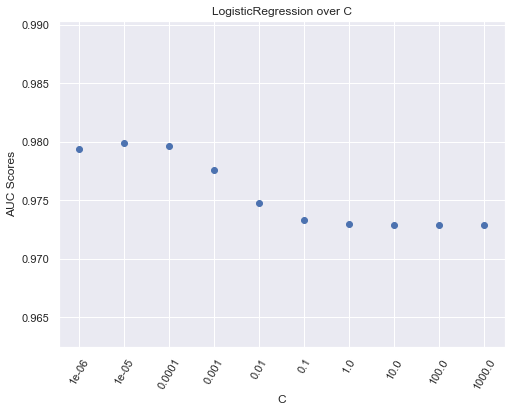

In [16]:
parameters = {
    'C': np.logspace(-6, 3, 10)
}
logReg_gSearch = grid_classifier(LogisticRegression(), scaled_vals, target, parameters=parameters, plot=True)

In [37]:
model = LogisticRegression(C=10**-5)
model = model_validate(model, scaled_vals, target)

Seconds to start: 0.00
Seconds to fit: 1.30
CV Score : Mean - 0.980 | Std - 0.001 | Min - 0.979 | Max - 0.981
Seconds to CV: 7.40


---
## KNN

Seconds to start: 0.00
Seconds to fit: 177.16
Grid Scores: 

{'mean_fit_time': array([0.56976199, 0.57061303, 0.68622267, 0.57605946, 0.44622552,
       0.47847652, 0.43868846, 0.61318356, 0.43313998, 0.44036591,
       0.41111094, 0.40646881, 0.40628898, 0.45924568, 0.39099848,
       0.731188  , 0.52033252]),
 'mean_score_time': array([1.55520505, 1.32392049, 1.66880435, 2.04419494, 1.76066041,
       2.14638376, 1.97914463, 2.53953946, 2.09142631, 2.26546246,
       2.50129104, 2.64290595, 3.07975227, 2.74733102, 3.13126069,
       3.31968182, 3.13595247]),
 'mean_test_score': array([0.96807265, 0.96803835, 0.97181257, 0.97354657, 0.97361843,
       0.97519933, 0.97470897, 0.97443746, 0.9752422 , 0.9763752 ,
       0.97590526, 0.97707582, 0.97665243, 0.97632539, 0.97643848,
       0.97597589, 0.97592608]),
 'mean_train_score': array([0.98338052, 0.98298158, 0.98284108, 0.98259997, 0.98280025,
       0.98267119, 0.98236066, 0.98200749, 0.98158328, 0.98112432,
       0.98052822, 0.979

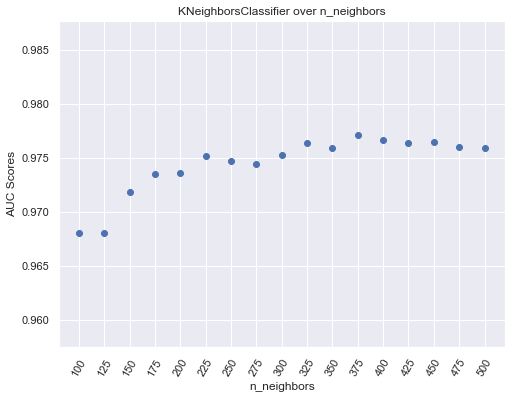

In [30]:
parameters = {
    'n_neighbors': np.arange(100, 501, 25)
}
knn_gSearch = grid_classifier(KNeighborsClassifier(), scaled_vals[:20000], target[:20000], parameters=parameters, plot=True)

In [41]:
model = KNeighborsClassifier(n_neighbors=375)
model = model_validate(model, scaled_vals[:50000], target[:50000])

Seconds to start: 0.00
Seconds to fit: 3.14
CV Score : Mean - 0.980 | Std - 0.005 | Min - 0.971 | Max - 0.989
Seconds to CV: 27.70


In [40]:
model = KNeighborsClassifier(n_neighbors=375)
model = model_validate(model, scaled_vals[:200000], target[:200000])

Seconds to start: 0.00
Seconds to fit: 28.95
CV Score : Mean - 0.981 | Std - 0.001 | Min - 0.980 | Max - 0.983
Seconds to CV: 274.41


Could train on whole dataset and go for an AUC of 0.982 but for now will wait until later (should take 45-60 mins to train locally)